<a href="https://colab.research.google.com/github/anguswilliams91/normalising_flows_pyro/blob/master/pyro_normalising_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyro-ppl

In [2]:
!pip install seaborn==0.11.0

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_moons
import torch as t

import pyro
from pyro import poutine
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoNormal
from pyro.optim import Adam

if t.cuda.is_available():
  t.set_default_tensor_type("torch.cuda.FloatTensor")

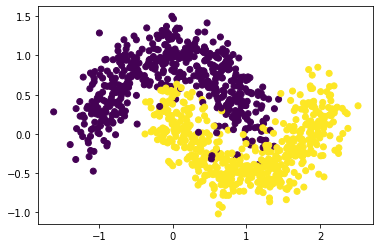

In [4]:
X, y = make_moons(n_samples=1000, noise=0.2)

plt.scatter(X[:, 0], X[:, 1], c=y);

In [5]:
def naive_bayes(X=None, y=None, n_samples=1000):

  p = pyro.sample("p", dist.Beta(2, 2))

  with pyro.plate("samples", n_samples) as i:
    label = pyro.sample("y", dist.Binomial(probs=p), obs=y)

  for i in range(2):
    mu = pyro.sample(f"mu_{i}", dist.Normal(t.zeros(2), 2).to_event(1))
    sigma = pyro.sample(f"sigma_{i}", dist.HalfNormal(t.ones(2) * 5).to_event(1))

    index = label.long() == i
    n_samples = index.sum()
    if n_samples > 0:
      with pyro.plate(f"conditional_density_{i}", n_samples):
        X_obs = X if X is None else X[label.long() == i]
        cov = t.diag(sigma)
        pyro.sample(f"X_{i}", dist.MultivariateNormal(mu, covariance_matrix=cov), obs=X_obs)

  return label

In [6]:
def to_tensor(X: np.array) -> t.Tensor:
  X = t.Tensor(X) 
  return X if not t.cuda.is_available() else X.cuda()

Loss after 0 steps:  861.29
Loss after 100 steps:  648.73
Loss after 200 steps:  628.46
Loss after 300 steps:  613.74
Loss after 400 steps:  588.12
Loss after 500 steps:  608.61


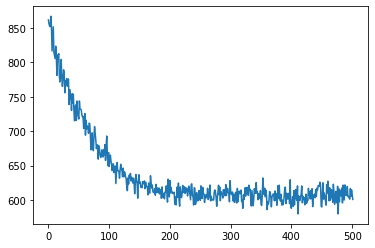

In [7]:
def train_model(model, n_steps=500):

  guide = AutoNormal(model)
  optimizer = Adam({"lr": 0.01})

  svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

  def data_generator(batch_size=256):
    while True:
      X_batch, y_batch = make_moons(n_samples=batch_size, noise=0.2)
      yield to_tensor(X_batch), to_tensor(y_batch)

  pyro.clear_param_store()
  losses = []
  for i, (X_batch, y_batch) in enumerate(data_generator()):
    loss = svi.step(X=X_batch, y=y_batch, n_samples=X_batch.shape[0])
    losses.append(loss)

    if not i % 100:
      print(f"Loss after {i} steps: {loss: .2f}")

    if i == n_steps + 1:
      break
  
  plt.plot(losses)

  return guide

naive_guide = train_model(naive_bayes)

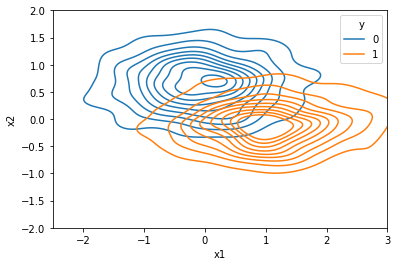

In [8]:
def plot_posterior_predictive(model, guide):
  posterior_predictive = Predictive(model, guide=guide, num_samples=1)
  samples = posterior_predictive.get_samples(y=to_tensor(y))

  X_0 = samples["X_0"].view(1 * 500, 2).detach().cpu().numpy()
  X_1 = samples["X_1"].view(1 * 500, 2).detach().cpu().numpy()

  model_samples = pd.DataFrame({
      "x1": np.concatenate((X_0[:, 0], X_1[:, 0])),
      "x2": np.concatenate((X_0[:, 1], X_1[:, 1])),
      "y": [0 for _ in range(500)] + [1 for _ in range(500)]
  })

  sns.kdeplot(data=model_samples, x="x1", y="x2", hue="y")
  plt.xlim((-2.5, 3))
  plt.ylim((-2, 2))
  return

plot_posterior_predictive(naive_bayes, naive_guide)

In [28]:
spline_transforms = [
    T.spline_coupling(2, count_bins=16),
    T.spline_coupling(2, count_bins=16)
]

def flow_bayes(X=None, y=None, n_samples=1000):

  pyro.module("spline_0", spline_transforms[0])
  pyro.module("spline_1", spline_transforms[1])

  p = pyro.sample("p", dist.Beta(2, 2))

  with pyro.plate("samples", n_samples) as i:
    label = pyro.sample("y", dist.Binomial(probs=p), obs=y)

  for i in range(2):
    index = label.long() == i
    n_instances = index.sum()
    if n_instances > 0:
      with pyro.plate(f"conditional_density_{i}", n_instances):
        X_obs = X if X is None else X[index]
        pyro.sample(f"X_{i}", dist.TransformedDistribution(
            dist.MultivariateNormal(
                t.zeros(2), 
                covariance_matrix=t.eye(2)
            ),
            [spline_transforms[i]],
        ), obs=X_obs)

  return label

Loss after 0 steps:  1149.54
Loss after 100 steps:  519.49
Loss after 200 steps:  480.13
Loss after 300 steps:  466.85
Loss after 400 steps:  465.21
Loss after 500 steps:  478.70


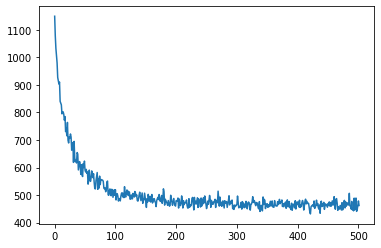

In [29]:
flow_guide = train_model(flow_bayes)

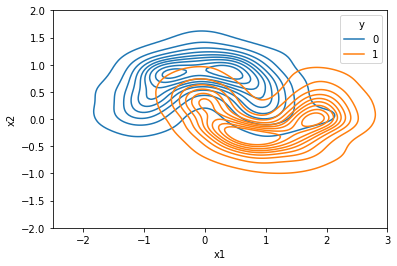

In [30]:
plot_posterior_predictive(flow_bayes, flow_guide)

In [70]:
def plot_probabilities(X, model, guide, n_samples=1):

  X = to_tensor(X)

  samples = []
  for _ in range(n_samples):

    guide_tr = poutine.trace(guide).get_trace(X=X, n_samples=X.shape[0])
    log_pr = []
    for i in range(2):
      model_tr = poutine.trace(
          poutine.replay(model, trace=guide_tr)
      ).get_trace(X=X, y=i * t.ones(X.shape[0]), n_samples=X.shape[0])
      model_tr.compute_log_prob()

      if i == 1:
        p = guide_tr.nodes["p"]["value"]
      else:
        p = 1 - guide_tr.nodes["p"]["value"]

      log_pr.append(model_tr.nodes[f"X_{i}"]["log_prob"] + t.log(p))

    pr = t.exp(t.stack(log_pr))
    pr = pr[1, :] / pr.sum(axis=0)
    samples.append(pr)
  
  post_pr = t.stack(samples).mean(axis=0)

  plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=pr.cpu().detach())
  plt.colorbar(label="Probability of positive class")
  return pr.cpu().detach().numpy()

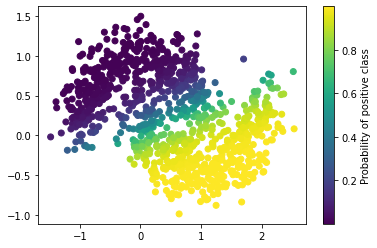

In [72]:
X_test, y_test = make_moons(n_samples=1000, noise=0.2)

pr_naive = plot_probabilities(X_test, naive_bayes, naive_guide, n_samples=100)

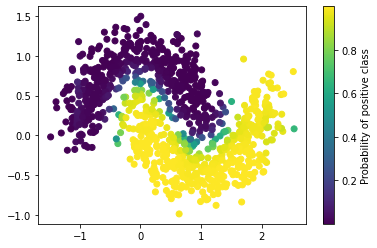

In [73]:
pr_flow = plot_probabilities(X_test, flow_bayes, flow_guide, n_samples=100)

In [54]:
t.log(pr_naive[y_test == 1]).sum()

tensor(-139.0972, grad_fn=<SumBackward0>)

In [55]:
t.log(pr_flow[y_test == 1]).sum()

tensor(-30.0749, grad_fn=<SumBackward0>)